# Text Dating: A Study in Document Regression

[Document classification](https://en.wikipedia.org/wiki/Document_classification) is a common application of machine learning techniques. Examples include [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis), the classification of texts into a (typically small) number of moods (such as "positive" and "negative"); as well as authorship attribution in [stylometry](https://en.wikipedia.org/wiki/Stylometry), in which texts are grouped according to their original author.

Unsupersived learning methods have also been applied to the analysis of documents. For instance, [doc2vec](https://arxiv.org/pdf/1405.4053v2.pdf) is a dimensionality reduction technique that extends [word embeddings] to documents.

But what about document *regression*? In this notebook, we investigate the problem of learning the date of a publication from the text contained therein. Since the target space, a range of years, can be viewed as a continuum, this problem presents a natural test case for applying regression techniques to document analysis.

In [1]:
import re
import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## The Gutenberg dataset

We will make use of the (updated) [Gutenberg dataset](https://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html), which consists of complete texts from over 3000 public domain books.

Unfortunately, the documents have already been stripped of metadata, including the year of publication. We attempt to resolve this issue by supposing that the first four-digit number appearing in each document (if any) is the date of publication.

The following loads texts for which a potential year of publication can be found into a dataframe.

In [3]:
%%time
text_dir = 'data/texts'
current_year = 2020

files = os.listdir(text_dir)

entries = []
for file in files:
    with open(os.path.join(text_dir, file)) as f:
        text = f.read().lower()

        result = re.search('\d\d\d\d', text)
        if result:
            i = result.start()
            year = int(text[i:i+4])
            text = text[i+5:].lower()
            
            # filter out impossible years
            if year <= current_year:
                entries.append((file, text, year))

docs = pd.DataFrame(entries, columns=['file', 'text', 'year'])

CPU times: user 23.6 s, sys: 1.4 s, total: 25 s
Wall time: 30.2 s


### A first look at the data

The plot below suggests an exponentially growing publication count throughout the years. This is actually quite reassuring in regards to our method for guessing publication date. However, this imbalance may be problematic later in our analysis and should be taken into account.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe527200b10>]],
      dtype=object)

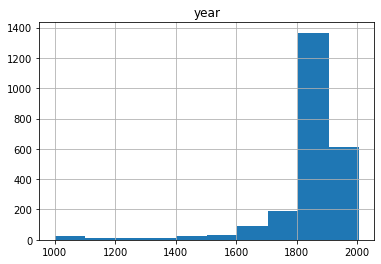

In [3]:
_ = docs.hist('year')

The sudden decrease in the number of publications in more recent years is likely explained by copyright law. The table shows the decrease beginning in the 1920s.

In [4]:
docs.groupby('year').count().tail(30).transpose()

year,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,...,1966,1967,1970,1972,1976,1980,1988,1991,2000,2006
file,38,41,40,24,26,29,30,26,26,3,...,2,1,1,1,2,1,1,2,16,1
text,38,41,40,24,26,29,30,26,26,3,...,2,1,1,1,2,1,1,2,16,1


The beginning of the histogram also contains an apparent anomaly, with a spike in publication count in the 11th century. As the table below shows, this is likely due to the disproportionate likelihood of the number 1000 appearing in a text.

In [5]:
docs.groupby('year').count().head(10).transpose()

year,1000,1001,1002,1007,1035,1050,1066,1090,1092,1099
file,10,3,1,2,2,2,2,1,1,2
text,10,3,1,2,2,2,2,1,1,2


We'll filter out this anomaly as well as the smaller number of publications after 1922.

In [4]:
docs = docs[(docs['year'] > 1000) & (docs['year'] < 1923)]

We still have some outliers to account for, as indicated in the box plot below.

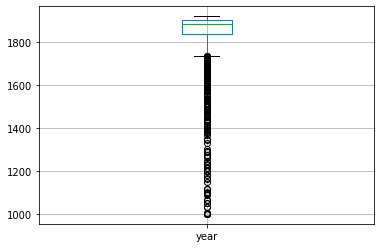

In [6]:
bp_data = docs.boxplot('year', return_type='dict')

We'll restrict our attention to the range of years between the min and max whiskers.

In [7]:
whisker_data = [whisker.get_ydata() for whisker in bp_data['whiskers']]
start = int(whisker_data[0][1])
stop = int(whisker_data[1][1])
start, stop

(1738, 1922)

In [8]:
docs = docs[(docs['year'] > start) & (docs['year'] < stop)]

Within our selected range, the growth in the number of publications is much more regular.

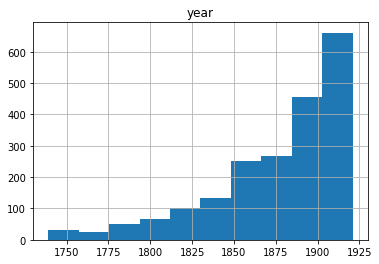

In [10]:
_ = docs.hist('year')

### Cleaning the data

Our main goal is to see if we can infer publication date from the words contained in a text. However, we might also conjecture that certain non-word features, such as punctuation density, may have some weight on our regression strategy.

The following first saves various punctuation statistics into a new dataframe and then cleans the texts, leaving only letters and white space.

In [11]:
features = pd.DataFrame()
features['year'] = docs['year']
features['length'] = docs['text'].apply(len)
features['sentences'] = docs['text'].apply(lambda text: len(text.split('.')))
features['semicolons'] = docs['text'].apply(lambda text: len(text.split(';')))
features['colons'] = docs['text'].apply(lambda text: len(text.split(':')))

In [9]:
%%time
table = str.maketrans("","", string.punctuation)
def clean(text):
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join(text.split())

docs['text'] = docs['text'].map(clean)

CPU times: user 42.5 s, sys: 5.2 s, total: 47.7 s
Wall time: 47.7 s


The process of cleaning the texts has left us with some empty texts, which we remove.

In [10]:
docs['text'].map(len).sort_values().head()

1495    0
2118    0
484     0
209     0
1811    0
Name: text, dtype: int64

In [11]:
docs = docs[docs['text'].map(len) > 0]

In [29]:
docs[docs['file'] == docs.iloc[0]['file']]['year']

0    1889
Name: year, dtype: int64

### Generating text segments

We presently have on training example per document. However, different documents may have greatly differing lengths. The various features in our dataset may be normalized by the document length, however we may have further issues if working with methods that require fixed length inputs.

Below, we split each document into a number of text segments taken therefrom. This not only averts any of the potential issues mentioned above, but also artificially generates additional training data.

In [33]:
def split_text(text, seg_length=10_000):
    words = text.split()
    return [' '.join(words[i:i+seg_length]) for i in range(0, len(words) // seg_length)]

segments = pd.DataFrame(docs[['file', 'text', 'year']])
segments['text'] = segments['text'].map(split_text)
segments = segments.explode('text').dropna()

,file,text,year
0,Charles Kingsley___The Heroes.txt,the right of translation if reserved printed b...,1889
0,Charles Kingsley___The Heroes.txt,right of translation if reserved printed by r ...,1889
0,Charles Kingsley___The Heroes.txt,of translation if reserved printed by r r clar...,1889
0,Charles Kingsley___The Heroes.txt,translation if reserved printed by r r clark e...,1889
2,Robert Louis Stevenson___The Works of Robert L...,that i was so unlucky as to fall at last into ...,1813


## Coarse feature analysis

Let's see if we can infer anything from the `features` dataframe we constructed earlier. We'll look at the average sentence length, average number of colons, and average number of semicolons in a text.

In [16]:
features['avg sentence length'] = features['length'] / features['sentences']
features['avg colons'] = features['colons'] / features['length']
features['avg semicolons'] = features['semicolons'] / features['length']

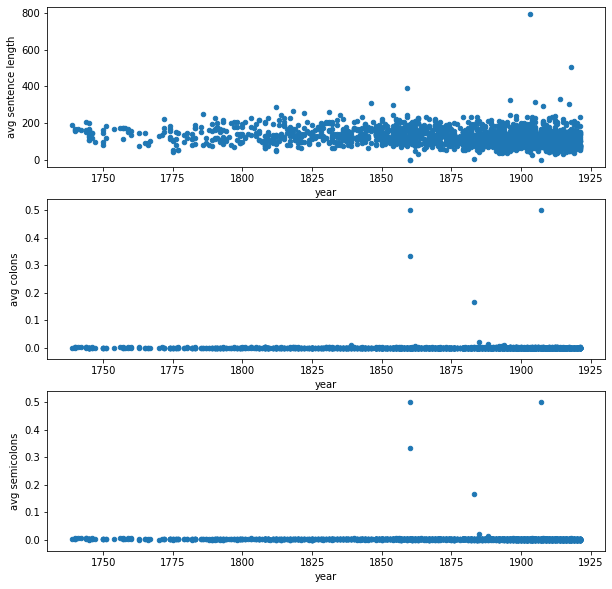

In [17]:
_, axs = plt.subplots(3, figsize=(10, 10))
features.plot.scatter(x='year', y='avg sentence length', ax=axs[0])
features.plot.scatter(x='year', y='avg colons', ax=axs[1])
_ = features.plot.scatter(x='year', y='avg semicolons', ax=axs[2])

Unfortunately, these features don't appear to be informative. However, it's always a good idea in text analysis to consider coarser features before doing a more refined analysis.

## Bag-of-words representation

A more refined analysis can be obtained by using word frequencies as features. This can be done using a [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model), in which a text is represented as a vector whose components components correspond to words in a vocabulary. The values of a component is a measure of the frequency of that word in the document.

Simply counting the number of occurences of a word is often a poor measure of frequency, as it may merely be indicative of text size (however, it is sensible in some situations, such as when performing classification with multinomial [naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)). A better solution would be to scale by the total number of words in a text.

An even more sophisticated approach is to look at the frequency of a word in a text in comparison to its frequency  in a corpus of texts. This is accomplished by the [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), or term frequency-inverse document frequency.

Below we use a tf-idf vectorizer with a minimum document frequency of 0.2 to filter out very uncommon words (e.g. typos). We also normalize the resulting vectors and apply sublinear scaling.

In [151]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.2, norm='l2', sublinear_tf=True)
X = vectorizer.fit_transform(segments['text'])

KeyboardInterrupt: 

## Simple linear regression

We begin by applying simple linear regression to our bag-of-words vectors. We'll split our data into training and test sets in order to evaluate our model.

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [157]:
y = segments['year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [158]:
%%time
linreg = LinearRegression()
linreg.fit(X_train, y_train)

CPU times: user 12min 50s, sys: 3min 19s, total: 16min 10s
Wall time: 8min 10s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [159]:
linreg.score(X_test, y_test)

0.9340410557693676

This isn pretty good for such a simple model. However note that the training score is significantly higher.

In [160]:
linreg.score(X_train, y_train)

0.9998205662399051

We're overfitting, which isn't surprising since we haven't used any form of regularization or cross-validation.

## Lasso

Note that bag-of-word vectors are typically *sparse*, meaning they consist of many 0 values. This is because there may be many more words in the full vocabulary than are used in a particular text. This is also why `TfidfVectorizer` returns an object of type `csr_matrix`.

In [192]:
type(X)

scipy.sparse.csr.csr_matrix

The `size` attribute of a `csr_matrix` indicates the number of non-zero values it contains, so we can compute the sparsity of `X` as follows.

In [190]:
1 - X.size / X.todense().size

0.5588352222874398

Actually, this isn't terribly sparse and it's probably due to the fact that our text segments are rather long. Nevertheless, it's still somewhat sparse, which makes it natural to consider the [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)?wprov=srpw1_0) method for this problem.

Lasso penalizes the $L_1$ norm of the regression coefficients and this is known to result in sparse regression coefficients. This is sensible in our case because there may be many words in the vocabulary that are not indicative of time period; lasso will select these automatically. Moreover, Lasso is [performant](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_dense_vs_sparse_data.html) when working with sparse data.

## Neural net regression

Although neural nets are probably most famous for classification tasks, they are highly versatile and can be used in many learning tasks, including regression as well as unsupervised learning. For linear regression with a feedforward network, all we need to do is specify a linear activation function on the last layer and use the mean squared error loss function.

In [145]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

In [146]:
model = Sequential()
model.add(Dense(250, input_dim=d))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Neural networks are very sensitive to data scaling, so we perform some additional preprocessing before training our network.

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X.todense())
y = sc.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [147]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
11204/11204 [==============================] - 11s 952us/step - loss: 3.2845
Epoch 2/10
11204/11204 [==============================] - 9s 800us/step - loss: 0.2613
Epoch 3/10
11204/11204 [==============================] - 10s 856us/step - loss: 0.1473
Epoch 4/10
11204/11204 [==============================] - 9s 823us/step - loss: 0.1099
Epoch 5/10
11204/11204 [==============================] - 10s 918us/step - loss: 0.0904
Epoch 6/10
11204/11204 [==============================] - 10s 872us/step - loss: 0.0802
Epoch 7/10
11204/11204 [==============================] - 10s 901us/step - loss: 0.0712
Epoch 8/10
11204/11204 [==============================] - 15s 1ms/step - loss: 0.0620
Epoch 9/10
11204/11204 [==============================] - 15s 1ms/step - loss: 0.0624
Epoch 10/10
11204/11204 [==============================] - 15s 1ms/step - loss: 0.0545


In [148]:
model.evaluate(X_test, y_test)

2801/2801 [==============================] - 1s 394us/step


0.06415101153771395